# Barotropic Streamfunction

The barotropic streamfunction ($\psi$) is obtained from the integration of the velocity field starting from a physical boundary at which we know the transport is zero. The difference between to streamlines is a measure of the transport between them. 

There are different ways to calculate it depending on your choice of boundary for the integration. This notebook calculates it integrating in the meridional space, starting from the Antarctic continent using the zonal velocity field:

$$
\psi = \int_{y_{\rm Antarctica}}^{y} U \, \mathrm{d}y ,
$$

where $U = \int u \, \mathrm{dz}$ is the depth-integrated $u$-velocity.

Initialise a dask client

In [1]:
import dask.distributed as dask
client = dask.Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 7.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46403,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41909,Total threads: 1
Dashboard: /proxy/33521/status,Memory: 3.50 GiB
Nanny: tcp://127.0.0.1:42217,


## Load data

The functions below will load the necessary data, and calculate the barotropic streamfunction

In [1]:
from esmvalcore.dataset import Dataset
from esmvalcore.preprocessor import (
    climate_statistics,
    regrid,
    axis_statistics )
import numpy as np
import iris

import iris.plot as iplt
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean

In [22]:

model_OM2 = Dataset(short_name='umo', project='CMIP6',
    activity='OMIP', mip="Omon", exp="omip2",
    ensemble="r1i1p1f1", timerange="0356/0366",
    dataset="ACCESS-OM2", grid="gn")

facets = {'dataset':"ACCESS-OM2-025"}
OM2_025 = model_OM2.copy(**facets).load()

model_OM2.load().summary(shorten=True)


'ocean_mass_x_transport / (kg s-1)   (time: 132; depth: 50; cell index along second dimension: 300; cell index along first dimension: 360)'

In [26]:

def zonal_transport(cube):
    """the zonal volume transport from `model`."""

    # the reference density
    p0 = 1035  # * ureg.kilogram / ureg.meter**3

    # 2d vertical sum
    cube = cube.collapsed('depth', iris.analysis.SUM)
    # divide by density for volume
    cube.data = cube.data / p0
    cube.data = cube.data / 1e6 # then divide by 10^6 for Sv
    ## long_name = "Ocean volume transport (1 Sv = 1e6 m3 s-1)" 
    cube.units = 'Sv'
    cube.long_name = 'Ocean volume transport'
 
    return cube

def calculate_streamfunction(model):
    """Compute the streamfunction psi for `model`."""
    cube_psi = zonal_transport(model)
    cube_psi = regrid(cube_psi, target_grid='0.5x0.5', scheme="linear")
    cube_psi.data = cube_psi.data.cumsum(1)  #latitude index 1
    
    cube_psi.long_name = 'Barotropic streamfunction'
    cube_psi.units = 'Sv'

    # psi mean
    cube_psi = climate_statistics(cube_psi, period='full', operator='mean')
    return cube_psi

## sftof? Ofx land mask anc


## Calculate the barotropic streamfunction and its time-mean

Now we compute the streamfunction using `calculate_streamfunction()`.

In [ ]:
## calculate
psi_mean = {}
psi_mean['ACCESS-OM2'] = calculate_streamfunction(model_OM2.load())
psi_mean['OM2-025'] = calculate_streamfunction(OM2_025)

## Let's plot


In [12]:
def circumpolar_map():
    fig = plt.figure(figsize = (12, 8))
    ax = plt.axes(projection = ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -80, -40], crs = ccrs.PlateCarree())
    ax.set_facecolor('lightgrey')
    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform = ax.transAxes)

    return fig, ax

Text(0.5, 1.0, 'Barotropic streamfunction from ')

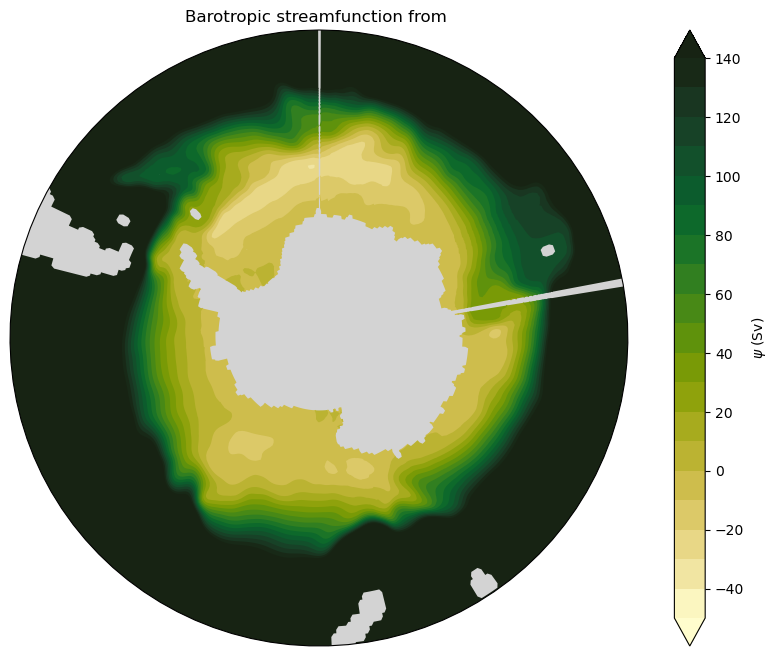

In [20]:
# for model in ['mom5', 'mom6']
fig, ax = circumpolar_map()

p1 = iplt.contourf(psi_mean['ACCESS-OM2'],
               levels = np.arange(-50, 150, 10),
               extend = 'both',
               cmap = cmocean.cm.speed,
               )
plt.colorbar(p1, orientation='vertical', label='$\psi$ (Sv)')

plt.title('Barotropic streamfunction from ACCESS-OM2')